# The credit fraud dataset - Synthesizing the minority class
In this notebook it's presented a practical exercise of how to use the avilable library GANs to synthesize tabular data.
For the purpose of this exercise it has been used the Credit Fraud dataset from Kaggle, that you can find here:https: //www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
import importlib

import pandas as pd
import numpy as np
import sklearn.cluster as cluster
import matplotlib.pyplot as plt

from models.gan import model
importlib.reload(model)

from models.gan.model import GAN
from preprocessing.credit_fraud import *

model = GAN


Bad key "text.kerning_factor" on line 4 in
/home/fabiana/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#Read the data
data = pd.read_csv('data/data_processed.csv', index_col=[0])
data_cols = list(data.columns[ data.columns != 'Class' ])
label_cols = ['Class']

print('Dataset columns: {}'.format(data_cols))
sorted_cols = ['V14', 'V4', 'V10', 'V17', 'Time', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23', 'Class']
data = data[ sorted_cols ].copy()

Dataset columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [3]:
#Before training the GAN do not forget to apply the required data transformations
#To ease here we've applied a PowerTransformation
data = transformations(data)

#For the purpose of this example we will only synthesize the minority class
train_data = data.loc[ data['Class']==1 ].copy()

print("Dataset info: Number of records - {} Number of varibles - {}".format(train_data.shape[0], train_data.shape[1]))

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_data[ data_cols ])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train_data.copy()
fraud_w_classes['Class'] = labels

Dataset info: Number of records - 492 Number of varibles - 31
   count
0    384
1    108


# GAN training

Below you can try to train your own generators using the available GANs architectures. You can train it either with labels (created using KMeans) or with no labels at all. 

Remeber that for this exercise in particular we've decided to synthesize only the minority class from the Credit Fraud dataset.

In [4]:
#Define the GAN and training parameters
noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
epochs = 5000+1
learning_rate = 5e-4
models_dir = './cache'

train_sample = fraud_w_classes.copy().reset_index(drop=True)
train_sample = pd.get_dummies(train_sample, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train_sample.columns if 'Class' in i ]
data_cols = [ i for i in train_sample.columns if i not in label_cols ]
train_sample[ data_cols ] = train_sample[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train_sample[ data_cols ]

gan_args = [batch_size, learning_rate, noise_dim, train_sample.shape[1], dim]
train_args = ['', epochs, log_step]

In [5]:
train_sample

,V14,V4,V10,V17,Time,V12,V26,Amount,V21,V8,...,V25,V24,V18,V2,V1,V5,V15,V9,V23,Class_1
0,-0.364140,0.247360,-0.284719,-0.306976,-0.208503,-0.227107,0.045838,-0.199245,0.071872,0.148524,...,0.004413,0.047312,-0.004068,0.136173,-0.127201,-0.038863,0.038433,-0.282337,-0.075195,0
1,-0.166205,0.152887,-0.077801,0.071059,-0.208294,-0.067495,-0.022004,0.181204,0.090903,-0.014051,...,0.051311,-0.057084,0.212486,-0.181909,-0.150359,0.099108,0.240807,-0.019959,0.230717,0
2,-0.147407,0.155290,-0.148970,-0.495555,-0.195564,-0.387155,-0.119771,0.137843,-0.039545,-0.044662,...,-0.033824,-0.024992,-0.298661,0.120709,-0.126902,-0.060265,-0.078791,-0.016853,0.026953,0
3,-0.530328,0.175246,-0.518688,-1.186117,-0.187380,-0.529034,-0.150364,0.059165,0.079316,-0.031046,...,0.045752,-0.019474,-0.569714,0.089320,-0.187225,-0.082049,-0.006559,-0.017755,-0.070646,0
4,-0.485576,0.285807,-0.248664,0.978364,-0.185638,-0.308949,0.115880,-0.153064,-0.051722,-0.053250,...,0.314021,-0.228582,0.383094,0.225762,0.066542,0.270500,-0.042050,-0.121053,-0.105072,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,-0.523543,0.121158,-0.612683,-0.475608,0.164417,-0.342881,0.152349,0.164564,0.106174,0.066094,...,0.104685,-0.057246,-0.154118,0.071608,-0.113806,-0.113019,0.039830,-0.204329,0.104693,0
488,-0.427730,0.100689,-0.336493,-0.350142,0.165773,-0.237416,0.144464,-0.161527,0.052358,0.017518,...,0.101398,-0.023974,-0.082700,0.084029,0.079401,0.031137,-0.070237,-0.104976,-0.024638,0
489,-0.347682,0.040168,-0.362882,-0.519358,0.165799,-0.220426,0.099463,0.074928,0.102687,0.126219,...,-0.138295,-0.005116,-0.061707,0.071662,-0.061751,-0.081511,-0.080171,-0.056997,0.029946,0
490,-0.507529,0.125210,-0.571613,-0.479788,0.169878,-0.326933,0.122500,0.138998,0.080595,0.108006,...,-0.065488,-0.040280,-0.172473,0.032122,-0.152446,-0.061618,0.009960,-0.157797,-0.073768,0


In [6]:
#Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer = model(gan_args)
synthesizer.train(train_sample, train_args)

0 [D loss: 0.713639, acc.: 21.48%] [G loss: 0.681439]
generated_data
1 [D loss: 0.685176, acc.: 50.39%] [G loss: 0.670198]
2 [D loss: 0.684121, acc.: 50.00%] [G loss: 0.657245]
3 [D loss: 0.674379, acc.: 50.00%] [G loss: 0.685362]
4 [D loss: 0.651105, acc.: 49.61%] [G loss: 0.757057]
5 [D loss: 0.672869, acc.: 49.22%] [G loss: 0.755655]
6 [D loss: 0.771544, acc.: 47.27%] [G loss: 0.646324]
7 [D loss: 0.817958, acc.: 43.75%] [G loss: 0.631879]
8 [D loss: 0.771024, acc.: 39.06%] [G loss: 0.761065]
9 [D loss: 0.688058, acc.: 58.20%] [G loss: 0.963590]
10 [D loss: 0.620855, acc.: 66.80%] [G loss: 1.123103]
11 [D loss: 0.610712, acc.: 64.84%] [G loss: 1.165010]
12 [D loss: 0.650455, acc.: 63.67%] [G loss: 1.021778]
13 [D loss: 0.681055, acc.: 63.28%] [G loss: 0.921371]
14 [D loss: 0.673429, acc.: 66.80%] [G loss: 0.919946]
15 [D loss: 0.646743, acc.: 71.88%] [G loss: 0.942330]
16 [D loss: 0.649137, acc.: 73.44%] [G loss: 0.911851]
17 [D loss: 0.652963, acc.: 73.44%] [G loss: 0.868513]
18 [D

146 [D loss: 0.681905, acc.: 60.16%] [G loss: 0.736231]
147 [D loss: 0.720413, acc.: 55.86%] [G loss: 0.774145]
148 [D loss: 0.645396, acc.: 57.03%] [G loss: 0.787421]
149 [D loss: 0.650365, acc.: 53.52%] [G loss: 0.869805]
150 [D loss: 0.640472, acc.: 57.81%] [G loss: 0.915170]
151 [D loss: 0.662183, acc.: 48.83%] [G loss: 0.907752]
152 [D loss: 0.661717, acc.: 51.95%] [G loss: 0.905770]
153 [D loss: 0.693026, acc.: 44.53%] [G loss: 0.856874]
154 [D loss: 0.728621, acc.: 37.50%] [G loss: 0.919105]
155 [D loss: 0.689714, acc.: 46.48%] [G loss: 0.968899]
156 [D loss: 0.656231, acc.: 61.72%] [G loss: 1.052211]
157 [D loss: 0.643109, acc.: 60.94%] [G loss: 1.159500]
158 [D loss: 0.636391, acc.: 60.55%] [G loss: 1.185298]
159 [D loss: 0.629624, acc.: 60.16%] [G loss: 1.147224]
160 [D loss: 0.633161, acc.: 62.50%] [G loss: 1.126819]
161 [D loss: 0.641448, acc.: 60.94%] [G loss: 1.087767]
162 [D loss: 0.654049, acc.: 57.03%] [G loss: 1.064663]
163 [D loss: 0.652273, acc.: 57.42%] [G loss: 1.

289 [D loss: 0.667190, acc.: 53.52%] [G loss: 0.802709]
290 [D loss: 0.697678, acc.: 43.75%] [G loss: 0.840475]
291 [D loss: 0.671932, acc.: 54.30%] [G loss: 0.851512]
292 [D loss: 0.675280, acc.: 51.56%] [G loss: 0.883612]
293 [D loss: 0.662816, acc.: 57.03%] [G loss: 0.867588]
294 [D loss: 0.663556, acc.: 56.64%] [G loss: 0.881581]
295 [D loss: 0.664815, acc.: 57.42%] [G loss: 0.875925]
296 [D loss: 0.660642, acc.: 58.98%] [G loss: 0.872280]
297 [D loss: 0.663362, acc.: 55.86%] [G loss: 0.838673]
298 [D loss: 0.689747, acc.: 52.73%] [G loss: 0.832205]
299 [D loss: 0.678087, acc.: 52.73%] [G loss: 0.819881]
300 [D loss: 0.714838, acc.: 44.92%] [G loss: 0.811127]
generated_data
301 [D loss: 0.708443, acc.: 46.09%] [G loss: 0.821831]
302 [D loss: 0.696810, acc.: 54.30%] [G loss: 0.839392]
303 [D loss: 0.685734, acc.: 60.16%] [G loss: 0.846957]
304 [D loss: 0.684352, acc.: 58.98%] [G loss: 0.851352]
305 [D loss: 0.680719, acc.: 58.59%] [G loss: 0.849613]
306 [D loss: 0.671693, acc.: 60.5

428 [D loss: 0.613487, acc.: 63.67%] [G loss: 0.831850]
429 [D loss: 0.620706, acc.: 60.55%] [G loss: 0.819133]
430 [D loss: 0.630581, acc.: 59.77%] [G loss: 0.860148]
431 [D loss: 0.622144, acc.: 64.06%] [G loss: 0.845826]
432 [D loss: 0.641443, acc.: 60.94%] [G loss: 0.844628]
433 [D loss: 0.634652, acc.: 59.77%] [G loss: 0.921144]
434 [D loss: 0.615511, acc.: 61.33%] [G loss: 0.984679]
435 [D loss: 0.618142, acc.: 60.94%] [G loss: 0.988632]
436 [D loss: 0.647191, acc.: 52.34%] [G loss: 0.985229]
437 [D loss: 0.614622, acc.: 61.72%] [G loss: 1.033191]
438 [D loss: 0.600019, acc.: 69.14%] [G loss: 1.033963]
439 [D loss: 0.599150, acc.: 69.14%] [G loss: 1.044661]
440 [D loss: 0.601306, acc.: 67.58%] [G loss: 1.016139]
441 [D loss: 0.596196, acc.: 71.09%] [G loss: 0.980932]
442 [D loss: 0.599102, acc.: 71.88%] [G loss: 0.932000]
443 [D loss: 0.607009, acc.: 72.27%] [G loss: 0.905092]
444 [D loss: 0.627672, acc.: 65.23%] [G loss: 0.887055]
445 [D loss: 0.627024, acc.: 66.80%] [G loss: 0.

574 [D loss: 0.596894, acc.: 67.97%] [G loss: 0.952581]
575 [D loss: 0.582806, acc.: 69.14%] [G loss: 0.910140]
576 [D loss: 0.596624, acc.: 67.58%] [G loss: 0.965074]
577 [D loss: 0.604439, acc.: 63.67%] [G loss: 0.924071]
578 [D loss: 0.599586, acc.: 66.02%] [G loss: 0.956706]
579 [D loss: 0.597957, acc.: 66.02%] [G loss: 0.960554]
580 [D loss: 0.596942, acc.: 67.97%] [G loss: 0.939427]
581 [D loss: 0.583465, acc.: 68.36%] [G loss: 0.945986]
582 [D loss: 0.569204, acc.: 73.05%] [G loss: 0.931690]
583 [D loss: 0.564999, acc.: 71.88%] [G loss: 0.928771]
584 [D loss: 0.590318, acc.: 67.19%] [G loss: 0.933531]
585 [D loss: 0.566235, acc.: 71.88%] [G loss: 0.866518]
586 [D loss: 0.587486, acc.: 66.02%] [G loss: 0.873195]
587 [D loss: 0.584312, acc.: 68.36%] [G loss: 0.841492]
588 [D loss: 0.600143, acc.: 65.23%] [G loss: 0.847597]
589 [D loss: 0.608262, acc.: 62.89%] [G loss: 0.832336]
590 [D loss: 0.619824, acc.: 62.11%] [G loss: 0.874543]
591 [D loss: 0.588963, acc.: 64.84%] [G loss: 0.

714 [D loss: 0.529812, acc.: 75.00%] [G loss: 1.135465]
715 [D loss: 0.549690, acc.: 71.48%] [G loss: 1.114131]
716 [D loss: 0.550406, acc.: 70.70%] [G loss: 1.059482]
717 [D loss: 0.569239, acc.: 69.92%] [G loss: 1.000421]
718 [D loss: 0.563761, acc.: 70.70%] [G loss: 1.024512]
719 [D loss: 0.539402, acc.: 73.05%] [G loss: 0.982400]
720 [D loss: 0.558133, acc.: 67.97%] [G loss: 0.973030]
721 [D loss: 0.551074, acc.: 72.27%] [G loss: 0.956675]
722 [D loss: 0.584487, acc.: 69.14%] [G loss: 0.901361]
723 [D loss: 0.571214, acc.: 69.14%] [G loss: 0.894146]
724 [D loss: 0.577086, acc.: 68.75%] [G loss: 0.897281]
725 [D loss: 0.603148, acc.: 64.06%] [G loss: 0.893730]
726 [D loss: 0.599543, acc.: 67.19%] [G loss: 0.941667]
727 [D loss: 0.607289, acc.: 65.23%] [G loss: 1.013586]
728 [D loss: 0.605344, acc.: 69.92%] [G loss: 1.033275]
729 [D loss: 0.562944, acc.: 73.44%] [G loss: 1.122651]
730 [D loss: 0.558360, acc.: 71.88%] [G loss: 1.179467]
731 [D loss: 0.524509, acc.: 75.78%] [G loss: 1.

857 [D loss: 0.541484, acc.: 73.83%] [G loss: 1.033122]
858 [D loss: 0.533450, acc.: 73.05%] [G loss: 1.045555]
859 [D loss: 0.551627, acc.: 70.31%] [G loss: 1.051266]
860 [D loss: 0.556791, acc.: 70.70%] [G loss: 0.999440]
861 [D loss: 0.598274, acc.: 68.75%] [G loss: 1.050696]
862 [D loss: 0.598174, acc.: 66.41%] [G loss: 1.056866]
863 [D loss: 0.593463, acc.: 66.41%] [G loss: 1.087111]
864 [D loss: 0.615763, acc.: 65.23%] [G loss: 1.152236]
865 [D loss: 0.570517, acc.: 71.09%] [G loss: 1.245868]
866 [D loss: 0.548360, acc.: 71.09%] [G loss: 1.230679]
867 [D loss: 0.536145, acc.: 72.27%] [G loss: 1.244323]
868 [D loss: 0.556352, acc.: 69.92%] [G loss: 1.257440]
869 [D loss: 0.548313, acc.: 72.27%] [G loss: 1.186143]
870 [D loss: 0.557210, acc.: 72.66%] [G loss: 1.077580]
871 [D loss: 0.556709, acc.: 69.53%] [G loss: 1.070722]
872 [D loss: 0.596523, acc.: 68.75%] [G loss: 1.048264]
873 [D loss: 0.566195, acc.: 69.92%] [G loss: 1.073147]
874 [D loss: 0.596812, acc.: 67.58%] [G loss: 1.

1000 [D loss: 0.482805, acc.: 77.34%] [G loss: 1.338090]
generated_data
1001 [D loss: 0.490969, acc.: 76.56%] [G loss: 1.334483]
1002 [D loss: 0.470641, acc.: 79.30%] [G loss: 1.235641]
1003 [D loss: 0.499583, acc.: 78.52%] [G loss: 1.263925]
1004 [D loss: 0.484280, acc.: 79.30%] [G loss: 1.241538]
1005 [D loss: 0.477598, acc.: 82.42%] [G loss: 1.197287]
1006 [D loss: 0.478500, acc.: 80.47%] [G loss: 1.188207]
1007 [D loss: 0.503286, acc.: 76.17%] [G loss: 1.148946]
1008 [D loss: 0.484323, acc.: 78.12%] [G loss: 1.182968]
1009 [D loss: 0.519202, acc.: 76.95%] [G loss: 1.255980]
1010 [D loss: 0.462563, acc.: 80.86%] [G loss: 1.157442]
1011 [D loss: 0.514276, acc.: 75.00%] [G loss: 1.211310]
1012 [D loss: 0.497738, acc.: 77.73%] [G loss: 1.268565]
1013 [D loss: 0.456740, acc.: 81.64%] [G loss: 1.228434]
1014 [D loss: 0.430437, acc.: 83.98%] [G loss: 1.204036]
1015 [D loss: 0.459203, acc.: 79.69%] [G loss: 1.175235]
1016 [D loss: 0.461892, acc.: 80.47%] [G loss: 1.217363]
1017 [D loss: 0.

1140 [D loss: 0.420391, acc.: 82.81%] [G loss: 1.457427]
1141 [D loss: 0.449380, acc.: 81.25%] [G loss: 1.584301]
1142 [D loss: 0.474640, acc.: 77.73%] [G loss: 1.712664]
1143 [D loss: 0.507560, acc.: 74.61%] [G loss: 1.780980]
1144 [D loss: 0.449919, acc.: 80.86%] [G loss: 1.804760]
1145 [D loss: 0.487237, acc.: 76.56%] [G loss: 1.722534]
1146 [D loss: 0.436677, acc.: 80.47%] [G loss: 1.632796]
1147 [D loss: 0.398616, acc.: 82.81%] [G loss: 1.671404]
1148 [D loss: 0.403872, acc.: 82.03%] [G loss: 1.649684]
1149 [D loss: 0.399701, acc.: 82.42%] [G loss: 1.643800]
1150 [D loss: 0.403419, acc.: 84.77%] [G loss: 1.564126]
1151 [D loss: 0.412175, acc.: 82.81%] [G loss: 1.532639]
1152 [D loss: 0.406675, acc.: 84.38%] [G loss: 1.687715]
1153 [D loss: 0.388524, acc.: 83.59%] [G loss: 1.660149]
1154 [D loss: 0.381158, acc.: 82.42%] [G loss: 1.727215]
1155 [D loss: 0.375127, acc.: 85.16%] [G loss: 1.897412]
1156 [D loss: 0.388188, acc.: 82.81%] [G loss: 1.818895]
1157 [D loss: 0.440545, acc.: 7

1286 [D loss: 0.350116, acc.: 86.33%] [G loss: 1.759917]
1287 [D loss: 0.385578, acc.: 84.77%] [G loss: 1.831321]
1288 [D loss: 0.360801, acc.: 82.42%] [G loss: 1.781470]
1289 [D loss: 0.341086, acc.: 86.72%] [G loss: 1.854708]
1290 [D loss: 0.361226, acc.: 85.55%] [G loss: 1.731730]
1291 [D loss: 0.385267, acc.: 85.16%] [G loss: 1.832307]
1292 [D loss: 0.358728, acc.: 85.16%] [G loss: 1.837168]
1293 [D loss: 0.348604, acc.: 86.72%] [G loss: 1.805035]
1294 [D loss: 0.345827, acc.: 85.55%] [G loss: 1.752907]
1295 [D loss: 0.375718, acc.: 84.77%] [G loss: 1.769172]
1296 [D loss: 0.363130, acc.: 84.38%] [G loss: 1.842273]
1297 [D loss: 0.375017, acc.: 83.98%] [G loss: 1.791397]
1298 [D loss: 0.339195, acc.: 85.16%] [G loss: 1.764147]
1299 [D loss: 0.358924, acc.: 85.16%] [G loss: 1.794078]
1300 [D loss: 0.350797, acc.: 84.38%] [G loss: 1.842415]
generated_data
1301 [D loss: 0.407942, acc.: 80.08%] [G loss: 1.909672]
1302 [D loss: 0.352306, acc.: 86.72%] [G loss: 1.808493]
1303 [D loss: 0.

1429 [D loss: 0.309608, acc.: 87.11%] [G loss: 1.856014]
1430 [D loss: 0.329347, acc.: 87.89%] [G loss: 1.997763]
1431 [D loss: 0.359651, acc.: 85.55%] [G loss: 2.206105]
1432 [D loss: 0.330535, acc.: 87.11%] [G loss: 1.869420]
1433 [D loss: 0.312414, acc.: 86.72%] [G loss: 2.034369]
1434 [D loss: 0.381458, acc.: 84.38%] [G loss: 2.031734]
1435 [D loss: 0.344592, acc.: 85.94%] [G loss: 1.999457]
1436 [D loss: 0.380991, acc.: 82.42%] [G loss: 2.002673]
1437 [D loss: 0.314931, acc.: 87.11%] [G loss: 1.937025]
1438 [D loss: 0.357989, acc.: 83.98%] [G loss: 2.016913]
1439 [D loss: 0.350998, acc.: 83.59%] [G loss: 1.815248]
1440 [D loss: 0.314762, acc.: 87.50%] [G loss: 2.062279]
1441 [D loss: 0.343479, acc.: 86.33%] [G loss: 1.918502]
1442 [D loss: 0.322074, acc.: 85.94%] [G loss: 2.009403]
1443 [D loss: 0.321210, acc.: 87.89%] [G loss: 1.942057]
1444 [D loss: 0.332262, acc.: 87.89%] [G loss: 2.085245]
1445 [D loss: 0.386224, acc.: 85.16%] [G loss: 2.028607]
1446 [D loss: 0.319157, acc.: 8

1570 [D loss: 0.314522, acc.: 87.11%] [G loss: 2.299756]
1571 [D loss: 0.276217, acc.: 89.84%] [G loss: 2.203218]
1572 [D loss: 0.282414, acc.: 87.11%] [G loss: 2.305270]
1573 [D loss: 0.286809, acc.: 89.06%] [G loss: 2.075467]
1574 [D loss: 0.276776, acc.: 88.28%] [G loss: 2.201333]
1575 [D loss: 0.302468, acc.: 85.55%] [G loss: 2.355569]
1576 [D loss: 0.288876, acc.: 89.45%] [G loss: 2.277505]
1577 [D loss: 0.297406, acc.: 87.89%] [G loss: 2.203768]
1578 [D loss: 0.305245, acc.: 87.89%] [G loss: 2.338322]
1579 [D loss: 0.284120, acc.: 87.89%] [G loss: 2.343747]
1580 [D loss: 0.294292, acc.: 88.67%] [G loss: 2.207284]
1581 [D loss: 0.282515, acc.: 88.28%] [G loss: 2.205789]
1582 [D loss: 0.286475, acc.: 88.67%] [G loss: 2.368837]
1583 [D loss: 0.269492, acc.: 90.23%] [G loss: 2.271060]
1584 [D loss: 0.312279, acc.: 87.50%] [G loss: 2.242857]
1585 [D loss: 0.261338, acc.: 90.62%] [G loss: 2.197358]
1586 [D loss: 0.278868, acc.: 89.45%] [G loss: 2.251966]
1587 [D loss: 0.286056, acc.: 8

1708 [D loss: 0.224455, acc.: 92.97%] [G loss: 2.626466]
1709 [D loss: 0.264471, acc.: 87.11%] [G loss: 2.682793]
1710 [D loss: 0.247672, acc.: 89.84%] [G loss: 2.522092]
1711 [D loss: 0.272879, acc.: 88.67%] [G loss: 2.570588]
1712 [D loss: 0.239651, acc.: 89.06%] [G loss: 2.434738]
1713 [D loss: 0.247633, acc.: 91.41%] [G loss: 2.508288]
1714 [D loss: 0.246433, acc.: 91.41%] [G loss: 2.531415]
1715 [D loss: 0.243023, acc.: 91.02%] [G loss: 2.442124]
1716 [D loss: 0.235466, acc.: 91.80%] [G loss: 2.761473]
1717 [D loss: 0.260709, acc.: 89.06%] [G loss: 2.497486]
1718 [D loss: 0.271576, acc.: 89.06%] [G loss: 2.625915]
1719 [D loss: 0.247916, acc.: 90.23%] [G loss: 2.618317]
1720 [D loss: 0.254372, acc.: 89.06%] [G loss: 2.546269]
1721 [D loss: 0.224392, acc.: 89.45%] [G loss: 2.473611]
1722 [D loss: 0.241546, acc.: 90.62%] [G loss: 2.811258]
1723 [D loss: 0.255922, acc.: 87.89%] [G loss: 2.633577]
1724 [D loss: 0.243465, acc.: 90.62%] [G loss: 2.500945]
1725 [D loss: 0.258223, acc.: 8

1850 [D loss: 0.210927, acc.: 91.02%] [G loss: 2.952666]
1851 [D loss: 0.223487, acc.: 89.84%] [G loss: 3.064902]
1852 [D loss: 0.226568, acc.: 89.45%] [G loss: 2.618999]
1853 [D loss: 0.215686, acc.: 92.97%] [G loss: 2.929680]
1854 [D loss: 0.209303, acc.: 87.89%] [G loss: 3.017206]
1855 [D loss: 0.239044, acc.: 90.23%] [G loss: 2.615219]
1856 [D loss: 0.201921, acc.: 92.58%] [G loss: 2.752103]
1857 [D loss: 0.229350, acc.: 90.62%] [G loss: 3.094285]
1858 [D loss: 0.220379, acc.: 89.84%] [G loss: 3.020247]
1859 [D loss: 0.258954, acc.: 87.11%] [G loss: 2.580580]
1860 [D loss: 0.219575, acc.: 92.19%] [G loss: 2.777477]
1861 [D loss: 0.208831, acc.: 91.02%] [G loss: 2.936878]
1862 [D loss: 0.216122, acc.: 91.80%] [G loss: 2.871621]
1863 [D loss: 0.234623, acc.: 90.62%] [G loss: 2.751443]
1864 [D loss: 0.210356, acc.: 90.23%] [G loss: 2.858923]
1865 [D loss: 0.222794, acc.: 90.23%] [G loss: 2.816053]
1866 [D loss: 0.203767, acc.: 93.75%] [G loss: 2.799397]
1867 [D loss: 0.218394, acc.: 8

1992 [D loss: 0.196247, acc.: 91.02%] [G loss: 3.181689]
1993 [D loss: 0.246102, acc.: 89.45%] [G loss: 3.041157]
1994 [D loss: 0.210147, acc.: 91.80%] [G loss: 3.268687]
1995 [D loss: 0.225471, acc.: 90.23%] [G loss: 2.715370]
1996 [D loss: 0.221405, acc.: 90.23%] [G loss: 3.033989]
1997 [D loss: 0.175568, acc.: 92.97%] [G loss: 3.122747]
1998 [D loss: 0.207928, acc.: 90.23%] [G loss: 3.119969]
1999 [D loss: 0.183780, acc.: 92.58%] [G loss: 2.791487]
2000 [D loss: 0.225443, acc.: 89.84%] [G loss: 2.927643]
generated_data
2001 [D loss: 0.217021, acc.: 90.62%] [G loss: 2.742185]
2002 [D loss: 0.221623, acc.: 89.84%] [G loss: 2.997497]
2003 [D loss: 0.199477, acc.: 91.02%] [G loss: 3.068550]
2004 [D loss: 0.237307, acc.: 91.02%] [G loss: 3.020389]
2005 [D loss: 0.249426, acc.: 88.28%] [G loss: 3.152505]
2006 [D loss: 0.256464, acc.: 89.06%] [G loss: 3.006216]
2007 [D loss: 0.266564, acc.: 87.11%] [G loss: 2.899145]
2008 [D loss: 0.236600, acc.: 89.84%] [G loss: 2.921183]
2009 [D loss: 0.

2134 [D loss: 0.219463, acc.: 91.41%] [G loss: 3.073784]
2135 [D loss: 0.183985, acc.: 93.36%] [G loss: 3.085935]
2136 [D loss: 0.230990, acc.: 89.45%] [G loss: 3.104795]
2137 [D loss: 0.210798, acc.: 91.02%] [G loss: 3.005907]
2138 [D loss: 0.205389, acc.: 90.62%] [G loss: 2.974116]
2139 [D loss: 0.193206, acc.: 92.19%] [G loss: 3.057049]
2140 [D loss: 0.249742, acc.: 89.84%] [G loss: 3.307632]
2141 [D loss: 0.207872, acc.: 90.62%] [G loss: 3.187674]
2142 [D loss: 0.216401, acc.: 90.62%] [G loss: 3.283356]
2143 [D loss: 0.216751, acc.: 89.45%] [G loss: 2.801646]
2144 [D loss: 0.205722, acc.: 90.23%] [G loss: 2.974492]
2145 [D loss: 0.214554, acc.: 90.62%] [G loss: 2.996907]
2146 [D loss: 0.195574, acc.: 92.19%] [G loss: 3.192800]
2147 [D loss: 0.205726, acc.: 92.19%] [G loss: 3.199484]
2148 [D loss: 0.192787, acc.: 91.41%] [G loss: 3.043826]
2149 [D loss: 0.178636, acc.: 92.97%] [G loss: 2.999194]
2150 [D loss: 0.220410, acc.: 92.58%] [G loss: 3.365135]
2151 [D loss: 0.209948, acc.: 8

2275 [D loss: 0.224652, acc.: 89.06%] [G loss: 3.281452]
2276 [D loss: 0.232231, acc.: 91.41%] [G loss: 3.170830]
2277 [D loss: 0.200542, acc.: 91.02%] [G loss: 3.295934]
2278 [D loss: 0.241018, acc.: 91.02%] [G loss: 3.066749]
2279 [D loss: 0.182169, acc.: 91.41%] [G loss: 3.143420]
2280 [D loss: 0.180503, acc.: 92.97%] [G loss: 3.171266]
2281 [D loss: 0.239282, acc.: 91.41%] [G loss: 3.222250]
2282 [D loss: 0.196424, acc.: 91.80%] [G loss: 3.010721]
2283 [D loss: 0.230556, acc.: 90.62%] [G loss: 3.048601]
2284 [D loss: 0.217047, acc.: 91.02%] [G loss: 3.350929]
2285 [D loss: 0.221763, acc.: 91.02%] [G loss: 3.007643]
2286 [D loss: 0.223204, acc.: 89.84%] [G loss: 3.315837]
2287 [D loss: 0.215940, acc.: 91.41%] [G loss: 3.143287]
2288 [D loss: 0.201180, acc.: 91.80%] [G loss: 3.110501]
2289 [D loss: 0.205665, acc.: 92.97%] [G loss: 2.979028]
2290 [D loss: 0.226960, acc.: 89.45%] [G loss: 3.211551]
2291 [D loss: 0.183308, acc.: 91.80%] [G loss: 3.451357]
2292 [D loss: 0.184296, acc.: 9

2414 [D loss: 0.236851, acc.: 91.80%] [G loss: 3.003191]
2415 [D loss: 0.232490, acc.: 90.62%] [G loss: 3.158238]
2416 [D loss: 0.246724, acc.: 88.67%] [G loss: 3.507708]
2417 [D loss: 0.230109, acc.: 89.84%] [G loss: 3.073065]
2418 [D loss: 0.208288, acc.: 91.80%] [G loss: 3.440991]
2419 [D loss: 0.206832, acc.: 90.62%] [G loss: 2.937757]
2420 [D loss: 0.215984, acc.: 92.19%] [G loss: 3.241250]
2421 [D loss: 0.199777, acc.: 92.19%] [G loss: 3.150856]
2422 [D loss: 0.239070, acc.: 88.67%] [G loss: 3.275987]
2423 [D loss: 0.204099, acc.: 91.80%] [G loss: 3.020484]
2424 [D loss: 0.206793, acc.: 90.23%] [G loss: 3.021471]
2425 [D loss: 0.193194, acc.: 92.19%] [G loss: 3.416215]
2426 [D loss: 0.202800, acc.: 90.62%] [G loss: 3.360479]
2427 [D loss: 0.196537, acc.: 90.62%] [G loss: 3.139064]
2428 [D loss: 0.213665, acc.: 91.02%] [G loss: 3.355772]
2429 [D loss: 0.194403, acc.: 92.19%] [G loss: 3.141553]
2430 [D loss: 0.194737, acc.: 91.80%] [G loss: 3.173600]
2431 [D loss: 0.198432, acc.: 9

2559 [D loss: 0.176378, acc.: 92.19%] [G loss: 3.661723]
2560 [D loss: 0.238530, acc.: 89.45%] [G loss: 3.014262]
2561 [D loss: 0.183671, acc.: 92.19%] [G loss: 2.859663]
2562 [D loss: 0.189385, acc.: 93.36%] [G loss: 3.251221]
2563 [D loss: 0.188649, acc.: 93.36%] [G loss: 3.182690]
2564 [D loss: 0.227027, acc.: 90.23%] [G loss: 3.145096]
2565 [D loss: 0.210059, acc.: 90.62%] [G loss: 3.206783]
2566 [D loss: 0.210049, acc.: 91.02%] [G loss: 3.153347]
2567 [D loss: 0.193715, acc.: 92.58%] [G loss: 3.177844]
2568 [D loss: 0.206168, acc.: 91.80%] [G loss: 3.231830]
2569 [D loss: 0.216104, acc.: 90.62%] [G loss: 3.039986]
2570 [D loss: 0.223701, acc.: 87.89%] [G loss: 3.602054]
2571 [D loss: 0.207273, acc.: 91.80%] [G loss: 3.323538]
2572 [D loss: 0.208961, acc.: 91.41%] [G loss: 3.131543]
2573 [D loss: 0.197129, acc.: 92.97%] [G loss: 3.213288]
2574 [D loss: 0.207091, acc.: 91.80%] [G loss: 3.437648]
2575 [D loss: 0.207766, acc.: 91.02%] [G loss: 3.143322]
2576 [D loss: 0.228699, acc.: 9

2700 [D loss: 0.212220, acc.: 91.41%] [G loss: 3.124276]
generated_data
2701 [D loss: 0.219580, acc.: 90.62%] [G loss: 2.930785]
2702 [D loss: 0.191008, acc.: 92.19%] [G loss: 3.077821]
2703 [D loss: 0.205870, acc.: 91.02%] [G loss: 3.477695]
2704 [D loss: 0.200296, acc.: 91.02%] [G loss: 3.080699]
2705 [D loss: 0.210938, acc.: 90.62%] [G loss: 3.029742]
2706 [D loss: 0.246559, acc.: 89.45%] [G loss: 3.187012]
2707 [D loss: 0.218246, acc.: 90.23%] [G loss: 3.384808]
2708 [D loss: 0.228643, acc.: 90.23%] [G loss: 3.405452]
2709 [D loss: 0.211266, acc.: 91.02%] [G loss: 3.120187]
2710 [D loss: 0.203197, acc.: 90.62%] [G loss: 3.416649]
2711 [D loss: 0.211702, acc.: 91.80%] [G loss: 3.209375]
2712 [D loss: 0.212382, acc.: 91.02%] [G loss: 3.166868]
2713 [D loss: 0.206742, acc.: 92.58%] [G loss: 3.135849]
2714 [D loss: 0.217331, acc.: 89.45%] [G loss: 3.217376]
2715 [D loss: 0.219336, acc.: 90.23%] [G loss: 3.259252]
2716 [D loss: 0.201778, acc.: 91.02%] [G loss: 2.816821]
2717 [D loss: 0.

2838 [D loss: 0.243294, acc.: 90.23%] [G loss: 3.065261]
2839 [D loss: 0.195007, acc.: 91.02%] [G loss: 3.210704]
2840 [D loss: 0.216364, acc.: 90.62%] [G loss: 2.944989]
2841 [D loss: 0.240584, acc.: 90.62%] [G loss: 2.937423]
2842 [D loss: 0.218841, acc.: 91.80%] [G loss: 3.009230]
2843 [D loss: 0.203002, acc.: 91.41%] [G loss: 2.932748]
2844 [D loss: 0.173832, acc.: 93.75%] [G loss: 3.085459]
2845 [D loss: 0.191645, acc.: 92.19%] [G loss: 3.319849]
2846 [D loss: 0.199385, acc.: 91.80%] [G loss: 3.098363]
2847 [D loss: 0.214601, acc.: 90.62%] [G loss: 3.189726]
2848 [D loss: 0.228302, acc.: 88.67%] [G loss: 3.414276]
2849 [D loss: 0.250706, acc.: 87.89%] [G loss: 3.497111]
2850 [D loss: 0.255832, acc.: 89.06%] [G loss: 2.932391]
2851 [D loss: 0.203018, acc.: 91.02%] [G loss: 2.953836]
2852 [D loss: 0.179897, acc.: 93.75%] [G loss: 3.109203]
2853 [D loss: 0.208747, acc.: 91.41%] [G loss: 2.774713]
2854 [D loss: 0.217689, acc.: 90.23%] [G loss: 3.331470]
2855 [D loss: 0.198384, acc.: 9

2979 [D loss: 0.211511, acc.: 91.80%] [G loss: 3.324703]
2980 [D loss: 0.185678, acc.: 91.41%] [G loss: 3.217559]
2981 [D loss: 0.194803, acc.: 91.80%] [G loss: 3.166070]
2982 [D loss: 0.238427, acc.: 91.02%] [G loss: 3.387433]
2983 [D loss: 0.211318, acc.: 92.19%] [G loss: 3.085310]
2984 [D loss: 0.195085, acc.: 92.97%] [G loss: 3.206366]
2985 [D loss: 0.221385, acc.: 91.02%] [G loss: 3.277457]
2986 [D loss: 0.225380, acc.: 91.80%] [G loss: 3.309742]
2987 [D loss: 0.203895, acc.: 92.19%] [G loss: 3.128898]
2988 [D loss: 0.204154, acc.: 91.41%] [G loss: 2.979080]
2989 [D loss: 0.203804, acc.: 91.02%] [G loss: 3.137160]
2990 [D loss: 0.213056, acc.: 91.41%] [G loss: 3.215862]
2991 [D loss: 0.239425, acc.: 89.84%] [G loss: 2.930157]
2992 [D loss: 0.209333, acc.: 91.41%] [G loss: 3.305667]
2993 [D loss: 0.224388, acc.: 91.41%] [G loss: 3.091745]
2994 [D loss: 0.205014, acc.: 91.02%] [G loss: 3.211444]
2995 [D loss: 0.224001, acc.: 90.23%] [G loss: 3.161223]
2996 [D loss: 0.204503, acc.: 9

3117 [D loss: 0.195940, acc.: 92.19%] [G loss: 3.408197]
3118 [D loss: 0.231025, acc.: 90.62%] [G loss: 3.085618]
3119 [D loss: 0.216703, acc.: 90.62%] [G loss: 3.164589]
3120 [D loss: 0.233317, acc.: 89.45%] [G loss: 3.148004]
3121 [D loss: 0.240336, acc.: 89.45%] [G loss: 3.092536]
3122 [D loss: 0.190789, acc.: 92.19%] [G loss: 3.451956]
3123 [D loss: 0.216323, acc.: 90.23%] [G loss: 3.259128]
3124 [D loss: 0.234514, acc.: 91.41%] [G loss: 3.118442]
3125 [D loss: 0.202324, acc.: 91.80%] [G loss: 3.312601]
3126 [D loss: 0.213363, acc.: 91.80%] [G loss: 3.283113]
3127 [D loss: 0.198406, acc.: 91.02%] [G loss: 3.167377]
3128 [D loss: 0.221531, acc.: 91.80%] [G loss: 3.296798]
3129 [D loss: 0.199500, acc.: 92.97%] [G loss: 3.140116]
3130 [D loss: 0.196401, acc.: 91.80%] [G loss: 3.147294]
3131 [D loss: 0.193101, acc.: 93.36%] [G loss: 3.197191]
3132 [D loss: 0.222473, acc.: 90.62%] [G loss: 3.270658]
3133 [D loss: 0.185645, acc.: 91.80%] [G loss: 3.186844]
3134 [D loss: 0.213252, acc.: 9

3259 [D loss: 0.221804, acc.: 90.62%] [G loss: 3.052696]
3260 [D loss: 0.193144, acc.: 92.19%] [G loss: 2.881387]
3261 [D loss: 0.218332, acc.: 91.41%] [G loss: 3.051818]
3262 [D loss: 0.183322, acc.: 92.58%] [G loss: 2.914141]
3263 [D loss: 0.202424, acc.: 92.19%] [G loss: 3.057936]
3264 [D loss: 0.200236, acc.: 91.02%] [G loss: 2.961039]
3265 [D loss: 0.206610, acc.: 91.80%] [G loss: 3.192878]
3266 [D loss: 0.197734, acc.: 93.36%] [G loss: 2.864965]
3267 [D loss: 0.212524, acc.: 91.02%] [G loss: 3.254114]
3268 [D loss: 0.209803, acc.: 92.19%] [G loss: 2.847898]
3269 [D loss: 0.207668, acc.: 91.02%] [G loss: 3.192830]
3270 [D loss: 0.194166, acc.: 91.02%] [G loss: 3.168416]
3271 [D loss: 0.220314, acc.: 90.23%] [G loss: 2.955105]
3272 [D loss: 0.224404, acc.: 91.41%] [G loss: 3.072029]
3273 [D loss: 0.196743, acc.: 91.41%] [G loss: 3.283156]
3274 [D loss: 0.223828, acc.: 91.41%] [G loss: 3.260068]
3275 [D loss: 0.204185, acc.: 91.41%] [G loss: 3.050850]
3276 [D loss: 0.194490, acc.: 9

generated_data
3401 [D loss: 0.199888, acc.: 91.80%] [G loss: 3.384395]
3402 [D loss: 0.183790, acc.: 91.41%] [G loss: 3.559539]
3403 [D loss: 0.247505, acc.: 89.06%] [G loss: 3.157753]
3404 [D loss: 0.228188, acc.: 91.02%] [G loss: 2.892535]
3405 [D loss: 0.196412, acc.: 91.41%] [G loss: 3.192333]
3406 [D loss: 0.212600, acc.: 90.62%] [G loss: 3.312400]
3407 [D loss: 0.199043, acc.: 90.62%] [G loss: 3.200106]
3408 [D loss: 0.215473, acc.: 92.19%] [G loss: 3.063544]
3409 [D loss: 0.199854, acc.: 91.80%] [G loss: 3.150291]
3410 [D loss: 0.194444, acc.: 91.02%] [G loss: 3.078541]
3411 [D loss: 0.192147, acc.: 92.58%] [G loss: 3.214370]
3412 [D loss: 0.205374, acc.: 91.80%] [G loss: 2.935696]
3413 [D loss: 0.189451, acc.: 91.80%] [G loss: 3.278944]
3414 [D loss: 0.196999, acc.: 90.62%] [G loss: 3.388503]
3415 [D loss: 0.178647, acc.: 91.02%] [G loss: 3.143029]
3416 [D loss: 0.208887, acc.: 91.80%] [G loss: 3.255010]
3417 [D loss: 0.184271, acc.: 92.19%] [G loss: 3.265577]
3418 [D loss: 0.

3539 [D loss: 0.214877, acc.: 90.62%] [G loss: 3.057652]
3540 [D loss: 0.189030, acc.: 92.58%] [G loss: 2.999772]
3541 [D loss: 0.202623, acc.: 92.19%] [G loss: 2.999969]
3542 [D loss: 0.186225, acc.: 92.19%] [G loss: 2.745382]
3543 [D loss: 0.200401, acc.: 91.80%] [G loss: 3.135795]
3544 [D loss: 0.212012, acc.: 91.41%] [G loss: 3.391410]
3545 [D loss: 0.200401, acc.: 91.80%] [G loss: 3.120350]
3546 [D loss: 0.207306, acc.: 91.80%] [G loss: 3.006004]
3547 [D loss: 0.186383, acc.: 92.19%] [G loss: 3.103083]
3548 [D loss: 0.191831, acc.: 91.41%] [G loss: 3.039757]
3549 [D loss: 0.197032, acc.: 91.41%] [G loss: 2.942042]
3550 [D loss: 0.223007, acc.: 91.02%] [G loss: 3.481015]
3551 [D loss: 0.223520, acc.: 89.45%] [G loss: 3.213147]
3552 [D loss: 0.225904, acc.: 91.02%] [G loss: 3.464876]
3553 [D loss: 0.212674, acc.: 91.41%] [G loss: 3.335679]
3554 [D loss: 0.218335, acc.: 91.02%] [G loss: 3.544358]
3555 [D loss: 0.222206, acc.: 90.62%] [G loss: 2.921831]
3556 [D loss: 0.197488, acc.: 9

3680 [D loss: 0.219936, acc.: 91.02%] [G loss: 3.006146]
3681 [D loss: 0.190352, acc.: 92.58%] [G loss: 3.353102]
3682 [D loss: 0.230852, acc.: 90.23%] [G loss: 3.252399]
3683 [D loss: 0.191396, acc.: 91.80%] [G loss: 3.008756]
3684 [D loss: 0.208926, acc.: 91.80%] [G loss: 3.258480]
3685 [D loss: 0.201963, acc.: 92.19%] [G loss: 3.115954]
3686 [D loss: 0.213545, acc.: 89.84%] [G loss: 3.328005]
3687 [D loss: 0.193145, acc.: 91.80%] [G loss: 3.386117]
3688 [D loss: 0.194222, acc.: 91.80%] [G loss: 2.788061]
3689 [D loss: 0.205494, acc.: 91.02%] [G loss: 2.960099]
3690 [D loss: 0.229621, acc.: 90.23%] [G loss: 3.100500]
3691 [D loss: 0.236416, acc.: 90.62%] [G loss: 3.252327]
3692 [D loss: 0.209840, acc.: 91.02%] [G loss: 3.225923]
3693 [D loss: 0.208094, acc.: 92.19%] [G loss: 2.903431]
3694 [D loss: 0.207125, acc.: 91.41%] [G loss: 2.931159]
3695 [D loss: 0.203434, acc.: 91.41%] [G loss: 2.933165]
3696 [D loss: 0.217998, acc.: 90.23%] [G loss: 3.022736]
3697 [D loss: 0.244779, acc.: 8

3817 [D loss: 0.215251, acc.: 91.02%] [G loss: 3.342755]
3818 [D loss: 0.207803, acc.: 90.23%] [G loss: 3.219933]
3819 [D loss: 0.196181, acc.: 92.97%] [G loss: 2.879823]
3820 [D loss: 0.176953, acc.: 92.97%] [G loss: 3.324287]
3821 [D loss: 0.205820, acc.: 91.02%] [G loss: 2.954540]
3822 [D loss: 0.216048, acc.: 90.62%] [G loss: 3.416169]
3823 [D loss: 0.210527, acc.: 91.80%] [G loss: 3.174439]
3824 [D loss: 0.207949, acc.: 91.41%] [G loss: 3.038632]
3825 [D loss: 0.203060, acc.: 92.19%] [G loss: 3.062369]
3826 [D loss: 0.209140, acc.: 92.19%] [G loss: 3.117868]
3827 [D loss: 0.224597, acc.: 90.23%] [G loss: 3.386531]
3828 [D loss: 0.209258, acc.: 91.80%] [G loss: 3.216639]
3829 [D loss: 0.199797, acc.: 91.02%] [G loss: 3.240300]
3830 [D loss: 0.193531, acc.: 91.02%] [G loss: 2.853677]
3831 [D loss: 0.199294, acc.: 91.02%] [G loss: 3.324312]
3832 [D loss: 0.202061, acc.: 91.41%] [G loss: 3.078754]
3833 [D loss: 0.203886, acc.: 92.19%] [G loss: 3.031008]
3834 [D loss: 0.202289, acc.: 9

3959 [D loss: 0.210593, acc.: 90.62%] [G loss: 3.563529]
3960 [D loss: 0.188039, acc.: 91.80%] [G loss: 3.407872]
3961 [D loss: 0.206520, acc.: 89.45%] [G loss: 2.996272]
3962 [D loss: 0.194524, acc.: 91.41%] [G loss: 3.237861]
3963 [D loss: 0.196341, acc.: 91.41%] [G loss: 3.061287]
3964 [D loss: 0.193302, acc.: 92.19%] [G loss: 3.432836]
3965 [D loss: 0.167472, acc.: 91.80%] [G loss: 3.407264]
3966 [D loss: 0.183356, acc.: 92.19%] [G loss: 3.530977]
3967 [D loss: 0.244058, acc.: 88.67%] [G loss: 3.207156]
3968 [D loss: 0.204733, acc.: 91.41%] [G loss: 2.973504]
3969 [D loss: 0.189579, acc.: 92.19%] [G loss: 2.942287]
3970 [D loss: 0.191566, acc.: 92.58%] [G loss: 3.315535]
3971 [D loss: 0.229242, acc.: 90.62%] [G loss: 3.085482]
3972 [D loss: 0.193160, acc.: 91.41%] [G loss: 3.503210]
3973 [D loss: 0.196864, acc.: 91.80%] [G loss: 3.327869]
3974 [D loss: 0.217337, acc.: 92.19%] [G loss: 3.217806]
3975 [D loss: 0.201136, acc.: 91.41%] [G loss: 3.470322]
3976 [D loss: 0.205866, acc.: 9

4100 [D loss: 0.207106, acc.: 90.23%] [G loss: 3.233778]
generated_data
4101 [D loss: 0.163930, acc.: 93.36%] [G loss: 2.976538]
4102 [D loss: 0.193222, acc.: 91.02%] [G loss: 3.167498]
4103 [D loss: 0.207270, acc.: 90.62%] [G loss: 3.323003]
4104 [D loss: 0.225057, acc.: 91.02%] [G loss: 2.844201]
4105 [D loss: 0.231929, acc.: 89.84%] [G loss: 3.053746]
4106 [D loss: 0.227295, acc.: 91.02%] [G loss: 3.307792]
4107 [D loss: 0.237637, acc.: 90.62%] [G loss: 3.185606]
4108 [D loss: 0.210793, acc.: 91.80%] [G loss: 3.574331]
4109 [D loss: 0.183435, acc.: 92.19%] [G loss: 3.311329]
4110 [D loss: 0.218536, acc.: 90.62%] [G loss: 3.187293]
4111 [D loss: 0.196435, acc.: 91.41%] [G loss: 3.380156]
4112 [D loss: 0.219531, acc.: 91.02%] [G loss: 3.063465]
4113 [D loss: 0.222322, acc.: 91.02%] [G loss: 3.215257]
4114 [D loss: 0.214427, acc.: 90.23%] [G loss: 3.444523]
4115 [D loss: 0.159753, acc.: 92.58%] [G loss: 3.574274]
4116 [D loss: 0.158329, acc.: 91.80%] [G loss: 3.401666]
4117 [D loss: 0.

4238 [D loss: 0.227663, acc.: 91.41%] [G loss: 2.850169]
4239 [D loss: 0.235195, acc.: 90.62%] [G loss: 2.880065]
4240 [D loss: 0.219633, acc.: 90.62%] [G loss: 3.815798]
4241 [D loss: 0.217155, acc.: 91.02%] [G loss: 3.273314]
4242 [D loss: 0.185738, acc.: 91.80%] [G loss: 3.370999]
4243 [D loss: 0.209892, acc.: 91.80%] [G loss: 2.853312]
4244 [D loss: 0.209629, acc.: 92.58%] [G loss: 3.083107]
4245 [D loss: 0.231747, acc.: 91.02%] [G loss: 3.363788]
4246 [D loss: 0.205214, acc.: 91.80%] [G loss: 3.224707]
4247 [D loss: 0.211093, acc.: 91.41%] [G loss: 3.029130]
4248 [D loss: 0.206822, acc.: 91.02%] [G loss: 3.153688]
4249 [D loss: 0.186569, acc.: 92.58%] [G loss: 3.351530]
4250 [D loss: 0.183390, acc.: 91.80%] [G loss: 3.254759]
4251 [D loss: 0.163169, acc.: 92.58%] [G loss: 3.277818]
4252 [D loss: 0.172433, acc.: 92.19%] [G loss: 3.409756]
4253 [D loss: 0.209335, acc.: 91.02%] [G loss: 3.137736]
4254 [D loss: 0.207781, acc.: 92.97%] [G loss: 3.621042]
4255 [D loss: 0.214434, acc.: 9

4379 [D loss: 0.184396, acc.: 92.19%] [G loss: 3.460671]
4380 [D loss: 0.167597, acc.: 92.58%] [G loss: 3.585206]
4381 [D loss: 0.165489, acc.: 92.97%] [G loss: 3.081629]
4382 [D loss: 0.183901, acc.: 92.58%] [G loss: 2.746973]
4383 [D loss: 0.169439, acc.: 92.97%] [G loss: 3.564846]
4384 [D loss: 0.192904, acc.: 92.19%] [G loss: 3.213401]
4385 [D loss: 0.169826, acc.: 92.58%] [G loss: 3.549271]
4386 [D loss: 0.147130, acc.: 92.58%] [G loss: 3.921195]
4387 [D loss: 0.180340, acc.: 92.58%] [G loss: 3.162116]
4388 [D loss: 0.193919, acc.: 92.58%] [G loss: 3.130574]
4389 [D loss: 0.184295, acc.: 91.80%] [G loss: 3.728048]
4390 [D loss: 0.208981, acc.: 92.58%] [G loss: 3.027075]
4391 [D loss: 0.224093, acc.: 90.23%] [G loss: 3.421118]
4392 [D loss: 0.233154, acc.: 91.02%] [G loss: 3.083958]
4393 [D loss: 0.220284, acc.: 91.80%] [G loss: 3.234635]
4394 [D loss: 0.234213, acc.: 90.62%] [G loss: 2.828939]
4395 [D loss: 0.187301, acc.: 92.58%] [G loss: 2.952398]
4396 [D loss: 0.189683, acc.: 9

4516 [D loss: 0.169546, acc.: 93.75%] [G loss: 3.346698]
4517 [D loss: 0.183766, acc.: 92.58%] [G loss: 3.140805]
4518 [D loss: 0.210928, acc.: 91.41%] [G loss: 3.332438]
4519 [D loss: 0.220143, acc.: 91.41%] [G loss: 3.085893]
4520 [D loss: 0.197013, acc.: 92.58%] [G loss: 3.337287]
4521 [D loss: 0.196833, acc.: 92.19%] [G loss: 3.243140]
4522 [D loss: 0.185669, acc.: 91.80%] [G loss: 3.152228]
4523 [D loss: 0.196980, acc.: 92.19%] [G loss: 3.016956]
4524 [D loss: 0.199131, acc.: 93.36%] [G loss: 3.508607]
4525 [D loss: 0.212729, acc.: 91.41%] [G loss: 3.297731]
4526 [D loss: 0.211933, acc.: 91.80%] [G loss: 3.337323]
4527 [D loss: 0.218075, acc.: 92.19%] [G loss: 3.071066]
4528 [D loss: 0.222388, acc.: 89.06%] [G loss: 3.023981]
4529 [D loss: 0.187043, acc.: 91.41%] [G loss: 3.534284]
4530 [D loss: 0.194963, acc.: 91.80%] [G loss: 3.589848]
4531 [D loss: 0.207728, acc.: 91.41%] [G loss: 3.244015]
4532 [D loss: 0.197987, acc.: 93.36%] [G loss: 3.205430]
4533 [D loss: 0.206543, acc.: 9

4657 [D loss: 0.204416, acc.: 92.19%] [G loss: 3.134442]
4658 [D loss: 0.207943, acc.: 90.62%] [G loss: 3.393978]
4659 [D loss: 0.218385, acc.: 90.23%] [G loss: 2.861731]
4660 [D loss: 0.190765, acc.: 92.19%] [G loss: 3.540374]
4661 [D loss: 0.180564, acc.: 91.80%] [G loss: 3.885613]
4662 [D loss: 0.158652, acc.: 93.75%] [G loss: 3.311375]
4663 [D loss: 0.171487, acc.: 93.36%] [G loss: 3.147031]
4664 [D loss: 0.197568, acc.: 91.41%] [G loss: 3.161523]
4665 [D loss: 0.211958, acc.: 91.80%] [G loss: 3.651923]
4666 [D loss: 0.175195, acc.: 92.58%] [G loss: 4.203863]
4667 [D loss: 0.182033, acc.: 92.19%] [G loss: 3.289543]
4668 [D loss: 0.160229, acc.: 92.58%] [G loss: 3.415336]
4669 [D loss: 0.182146, acc.: 92.97%] [G loss: 3.473017]
4670 [D loss: 0.158928, acc.: 93.75%] [G loss: 3.113698]
4671 [D loss: 0.216767, acc.: 91.80%] [G loss: 3.311017]
4672 [D loss: 0.192764, acc.: 92.97%] [G loss: 3.204520]
4673 [D loss: 0.205125, acc.: 92.19%] [G loss: 3.296970]
4674 [D loss: 0.181813, acc.: 9

4800 [D loss: 0.179256, acc.: 91.80%] [G loss: 3.749772]
generated_data
4801 [D loss: 0.158764, acc.: 92.97%] [G loss: 3.995684]
4802 [D loss: 0.152402, acc.: 93.36%] [G loss: 3.409022]
4803 [D loss: 0.148057, acc.: 92.97%] [G loss: 3.850687]
4804 [D loss: 0.187873, acc.: 91.80%] [G loss: 3.257323]
4805 [D loss: 0.172295, acc.: 92.19%] [G loss: 3.271387]
4806 [D loss: 0.165915, acc.: 92.58%] [G loss: 4.426965]
4807 [D loss: 0.145493, acc.: 93.75%] [G loss: 3.205461]
4808 [D loss: 0.172365, acc.: 92.58%] [G loss: 3.490598]
4809 [D loss: 0.190996, acc.: 90.62%] [G loss: 3.807270]
4810 [D loss: 0.213930, acc.: 91.41%] [G loss: 3.416676]
4811 [D loss: 0.190925, acc.: 92.58%] [G loss: 3.673972]
4812 [D loss: 0.192311, acc.: 91.80%] [G loss: 3.495692]
4813 [D loss: 0.216735, acc.: 90.23%] [G loss: 3.229908]
4814 [D loss: 0.203274, acc.: 91.41%] [G loss: 3.530993]
4815 [D loss: 0.211571, acc.: 89.84%] [G loss: 3.651292]
4816 [D loss: 0.191517, acc.: 92.19%] [G loss: 3.133591]
4817 [D loss: 0.

4938 [D loss: 0.232701, acc.: 91.02%] [G loss: 3.037869]
4939 [D loss: 0.198277, acc.: 91.80%] [G loss: 3.121519]
4940 [D loss: 0.193941, acc.: 90.62%] [G loss: 3.421009]
4941 [D loss: 0.177137, acc.: 92.97%] [G loss: 3.691541]
4942 [D loss: 0.193000, acc.: 92.58%] [G loss: 3.236797]
4943 [D loss: 0.204184, acc.: 90.23%] [G loss: 3.350921]
4944 [D loss: 0.182708, acc.: 91.02%] [G loss: 3.872222]
4945 [D loss: 0.187839, acc.: 92.19%] [G loss: 3.698518]
4946 [D loss: 0.184384, acc.: 92.58%] [G loss: 3.200753]
4947 [D loss: 0.202221, acc.: 90.62%] [G loss: 3.414512]
4948 [D loss: 0.209575, acc.: 92.19%] [G loss: 3.264449]
4949 [D loss: 0.174162, acc.: 93.36%] [G loss: 4.208138]
4950 [D loss: 0.220193, acc.: 91.02%] [G loss: 3.435091]
4951 [D loss: 0.164542, acc.: 93.36%] [G loss: 3.987699]
4952 [D loss: 0.173061, acc.: 92.97%] [G loss: 3.367356]
4953 [D loss: 0.189814, acc.: 92.58%] [G loss: 3.317192]
4954 [D loss: 0.211748, acc.: 91.80%] [G loss: 3.927263]
4955 [D loss: 0.206383, acc.: 9

In [7]:
#You can easily save the trained generator and loaded it aftwerwards
synthesizer.save('models/gan/saved', 'generator_fraud')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/gan/saved/generator_fraud/assets


In [9]:
synthesizer.generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 32)]               0         
_________________________________________________________________
dense (Dense)                (128, 128)                4224      
_________________________________________________________________
dense_1 (Dense)              (128, 256)                33024     
_________________________________________________________________
dense_2 (Dense)              (128, 512)                131584    
_________________________________________________________________
dense_3 (Dense)              (128, 31)                 15903     
Total params: 184,735
Trainable params: 184,735
Non-trainable params: 0
_________________________________________________________________


In [ ]:
synthesizer.discriminator.summary()

In [ ]:
# Setup parameters visualization parameters
seed = 17
test_size = 492 # number of fraud cases
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=train_sample, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols+label_cols)
labels = fraud_w_classes['Class']

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']
class_labels = ['Class 1','Class 2']

col1, col2 = 'V17', 'V10'

base_dir = 'cache/'

#Actual fraud data visualization
model_steps = [ 0, 200, 500, 1000, 5000]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker, label in zip(real_samples.groupby('Class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]], 
                         label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()    
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    

In [10]:
 if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    for i, model_name in enumerate( model_names[:] ):
        
        [ model_name, with_class, type0, generator_model ] = models[model_name]
        
        generator_model.load_weights( base_dir + model_name + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )
        
        if with_class:
            g_z = generator_model.predict([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
            for group, color, marker, label in zip( gen_samples.groupby('Class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]], 
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model.predict(z)
            gen_samples = pd.DataFrame(g_z, columns=data_cols)
            gen_samples.to_csv('Generated_sample.csv')
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]], 
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(data_cols[0])
        ax.set_xlim(xlims), ax.set_ylim(ylims)


plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('Comparison_of_GAN_outputs.png')



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 31)]               0         
_________________________________________________________________
dense_4 (Dense)              (128, 512)                16384     
_________________________________________________________________
dropout (Dropout)            (128, 512)                0         
_________________________________________________________________
dense_5 (Dense)              (128, 256)                131328    
_________________________________________________________________
dropout_1 (Dropout)          (128, 256)                0         
_________________________________________________________________
dense_6 (Dense)              (128, 128)                32896     
_________________________________________________________________
dense_7 (Dense)              (128, 1)                  129 

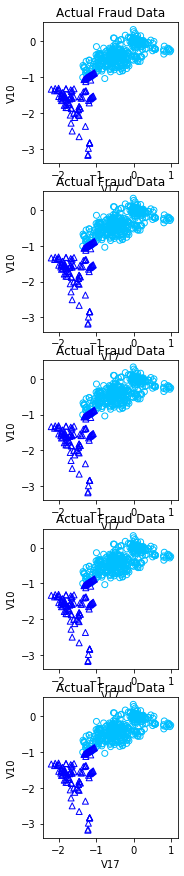

In [24]:
# Setup parameters visualization parameters
seed = 17
test_size = 492 # number of fraud cases
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=train_sample, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols+label_cols)
labels = fraud_w_classes['Class']

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']
class_labels = ['Class 1','Class 2']

col1, col2 = 'V17', 'V10'

base_dir = 'cache/'

#Actual fraud data visualization
model_steps = [ 0, 200, 500, 1000, 5000]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker, label in zip(real_samples.groupby('Class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]], 
                         label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()    
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    

In [ ]:
 if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    for i, model_name in enumerate( model_names[:] ):
        
        [ model_name, with_class, type0, generator_model ] = models[model_name]
        
        generator_model.load_weights( base_dir + model_name + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )
        
        if with_class:
            g_z = generator_model.predict([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
            for group, color, marker, label in zip( gen_samples.groupby('Class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]], 
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model.predict(z)
            gen_samples = pd.DataFrame(g_z, columns=data_cols)
            gen_samples.to_csv('Generated_sample.csv')
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]], 
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(data_cols[0])
        ax.set_xlim(xlims), ax.set_ylim(ylims)


plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('Comparison_of_GAN_outputs.png')

